In [46]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot
from auto_cov import plot_autocovariance

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [47]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

  0%|          | 3/1100 [00:00<00:40, 27.14it/s]

100%|██████████| 1100/1100 [00:40<00:00, 27.21it/s]


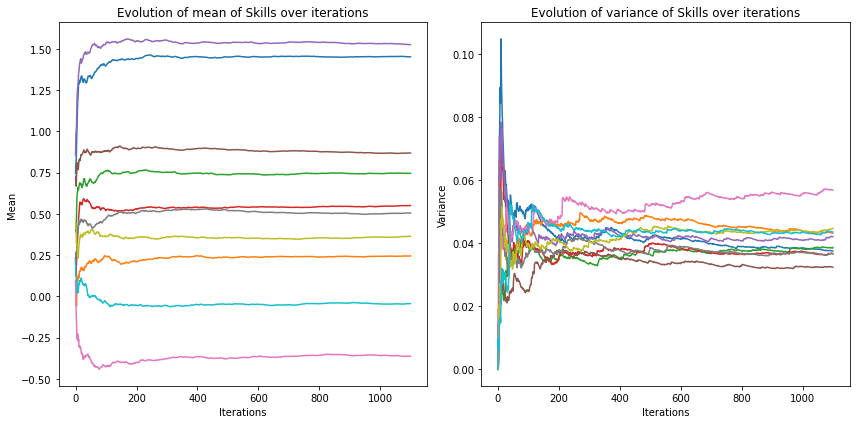

In [48]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples, mean_gibbs, variance_gibbs = gibbs_sample(G, M, num_iters)#, random_nums)

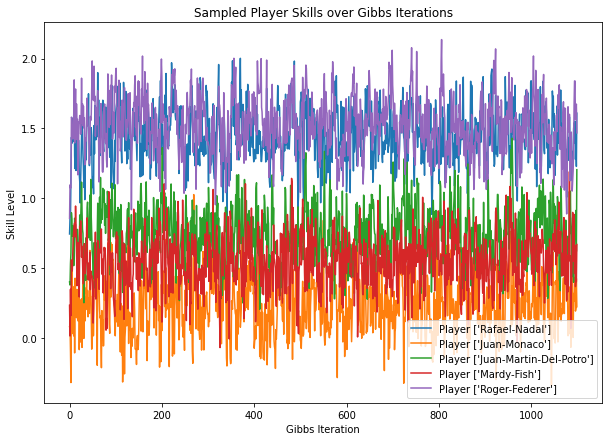

In [76]:
players_to_plot = range(5)  # As an example, we plot the first 5 players
    
# Plot the skill samples for the selected players
plt.figure(figsize=(10, 7))
for player in players_to_plot:
    plt.plot(skill_samples[player, :], label=f'Player {W[player]}')

plt.title('Sampled Player Skills over Gibbs Iterations')
plt.xlabel('Gibbs Iteration')
plt.ylabel('Skill Level')
plt.legend()
plt.show()

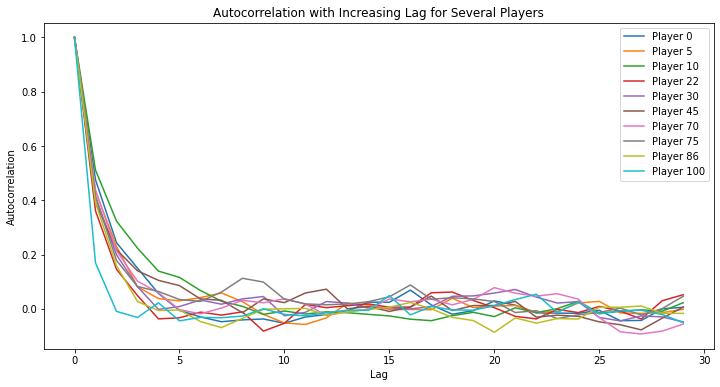

In [82]:
import pandas as pd
# Code for plotting the autocorrelation function for player p
player_indices = [0, 5, 10, 22, 30, 45, 70, 75, 86, 100]
autocor = np.zeros(10)
lags = 30  # Define the number of lags
autocorrelation_data = np.zeros((len(player_indices), lags))

# Calculate autocorrelation for each player at each lag
for idx, player_index in enumerate(player_indices):
    for lag in range(lags):
        autocorrelation_data[idx, lag] = pd.Series(skill_samples[player_index, :]).autocorr(lag=lag)

# Plot the autocorrelation for each player
plt.figure(figsize=(12, 6))
for idx, player_index in enumerate(player_indices):
    plt.plot(autocorrelation_data[idx, :], label=f'Player {player_index}')

plt.title('Autocorrelation with Increasing Lag for Several Players')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

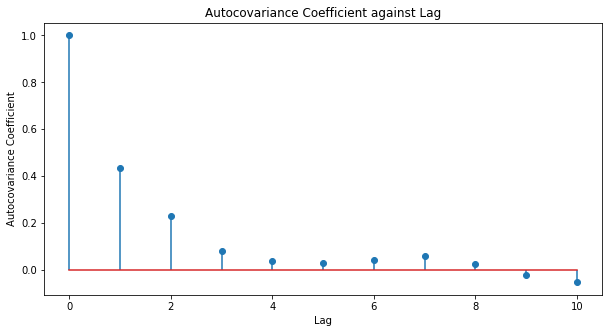

In [51]:
# Define the maximum lag to calculate the autocovariance coefficient
max_lag = 10  # For example, up to 100 lags
player_samples = skill_samples[p, :]
plot_autocovariance(player_samples, max_lag)

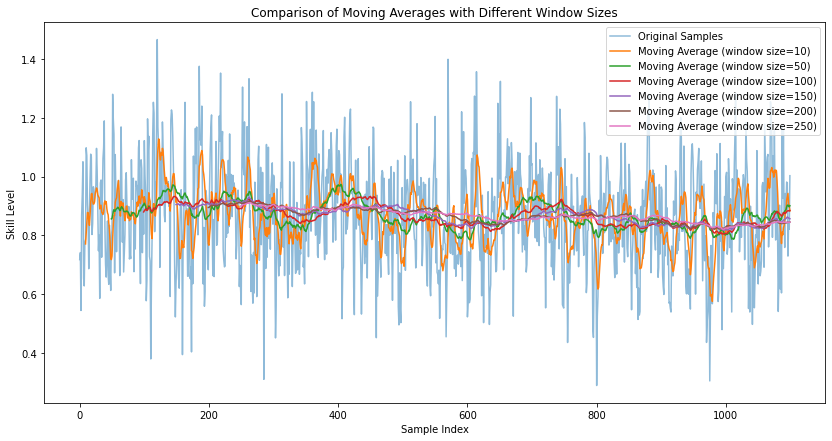

In [52]:
# Calculate the moving average (MA) of the samples
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_multiple_moving_averages(samples, window_sizes):
    plt.figure(figsize=(14, 7))
    
    # Plot the original samples
    plt.plot(samples, label='Original Samples', alpha=0.5)
    
    # Calculate and plot the moving averages for each window size
    for window_size in window_sizes:
        ma_samples = moving_average(samples, window_size)
        plt.plot(np.arange(window_size - 1, len(samples)), ma_samples, 
                 label=f'Moving Average (window size={window_size})')

    # Customize the plot
    plt.xlabel('Sample Index')
    plt.ylabel('Skill Level')
    plt.title('Comparison of Moving Averages with Different Window Sizes')
    plt.legend()
    plt.show()

# Define different window sizes for comparison
window_sizes = [10, 50, 100, 150, 200, 250]

# Plot the moving averages for the different window sizes
plot_multiple_moving_averages(player_samples, window_sizes)



# EP ranking

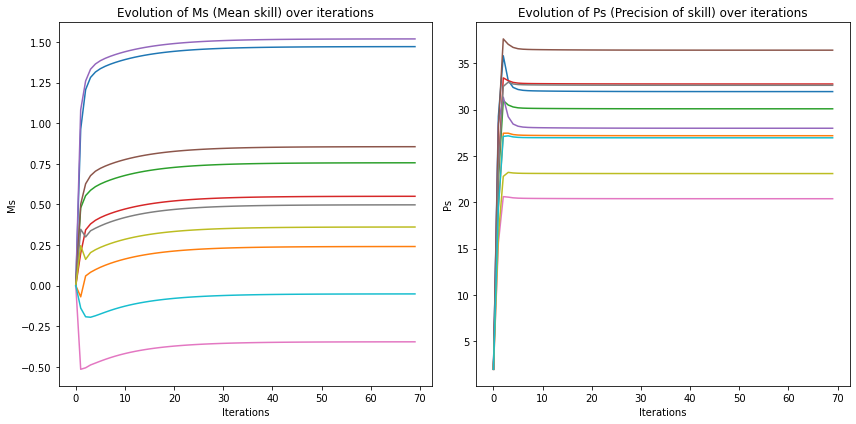

In [84]:
iterations = 70
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, iterations)

# Plotting the values of Ms_iterations and Ps_iterations against iterations

iter_range = np.arange(iterations)

# Setting up the plots
plt.figure(figsize=(12, 6))

# Plot for Ms (Mean skills for all players)
plt.subplot(1, 2, 1)
for i in range(10):
    plt.plot(iter_range, mean_player_skills[i, :], label=f'Player {i}')
plt.title('Evolution of Ms (Mean skill) over iterations')
plt.xlabel('Iterations')
plt.ylabel('Ms')

# Plot for Ps (Precision of skills for all players)
plt.subplot(1, 2, 2)
for i in range(10):
    plt.plot(iter_range, precision_player_skills[i, :], label=f'Player {i}')
plt.title('Evolution of Ps (Precision of skill) over iterations')
plt.xlabel('Iterations')
plt.ylabel('Ps')

plt.tight_layout()
plt.show()

In [54]:
id =  np.ones(4)
for i in range(W.size):
    name = W[i][0]
    if name == 'Novak-Djokovic':
        id[0]=int(i)
    elif name == 'Rafael-Nadal':
        id[1]=int(i)
    elif name == 'Roger-Federer':
        id[2]=int(i)
    elif name == 'Andy-Murray':
        id[3]=int(i)
id

array([15.,  0.,  4., 10.])

In [55]:
from scipy.stats import norm

In [56]:
def higher_skill(player1, player2, means, precisions, perf_var=0):
    player1 = int(player1)
    player2 = int(player2)
    mean = means[player1, -1] - means[player2, -1]
    var = 1/precisions[player1, -1] + 1/precisions[player2, -1] + perf_var
    prob = 1- norm.cdf((0-mean)/(var**0.5)) # Z-score normalization to turn the horizontal axis to sd
    return prob

In [57]:
higher_skill_prob_matrix = np.ones((4, 4))
for cols in range(4):
    for rows in range(4):
        higher_skill_prob_matrix[rows, cols] = higher_skill(id[cols], id[rows], mean_player_skills, precision_player_skills)

In [58]:
higher_skill_prob_matrix

array([[0.5       , 0.06014977, 0.09110451, 0.01468178],
       [0.93985023, 0.5       , 0.57289928, 0.23358018],
       [0.90889549, 0.42710072, 0.5       , 0.18920345],
       [0.98531822, 0.76641982, 0.81079655, 0.5       ]])

In [59]:
higher_perf_prob_matrix = np.ones((4, 4))
for cols in range(4):
    for rows in range(4):
        higher_perf_prob_matrix[rows, cols] = higher_skill(id[cols], id[rows], mean_player_skills, precision_player_skills, perf_var=1)

In [60]:
higher_perf_prob_matrix

array([[0.5       , 0.34461704, 0.36197256, 0.28018991],
       [0.65538296, 0.5       , 0.51836868, 0.42692529],
       [0.63802744, 0.48163132, 0.5       , 0.40913945],
       [0.71981009, 0.57307471, 0.59086055, 0.5       ]])

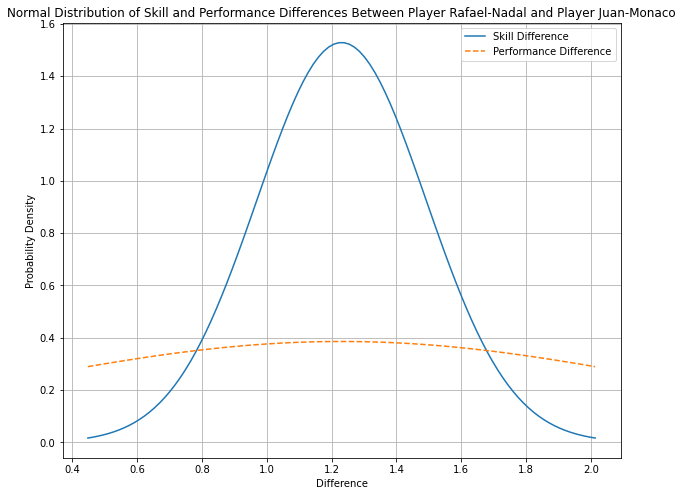

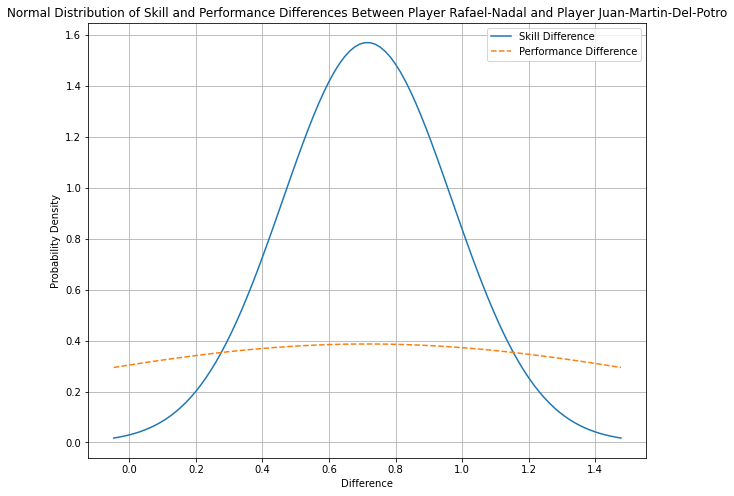

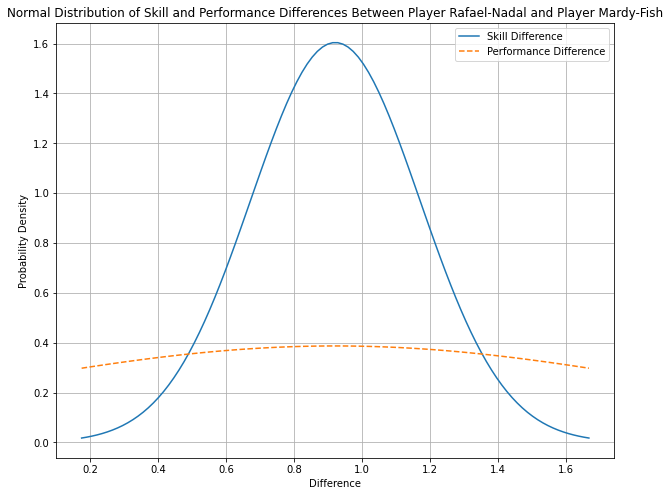

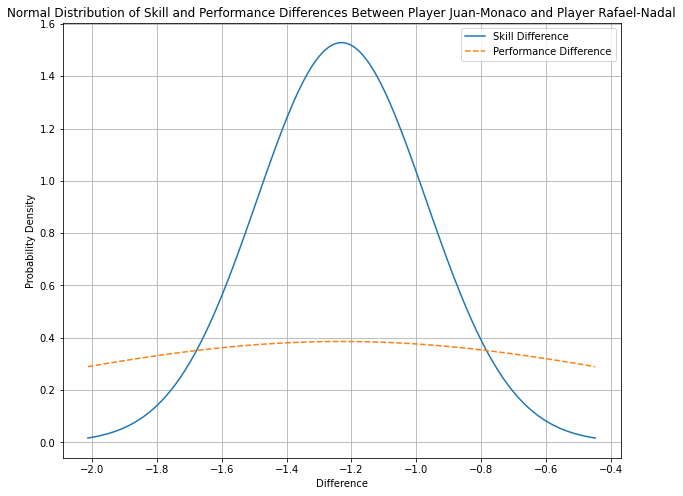

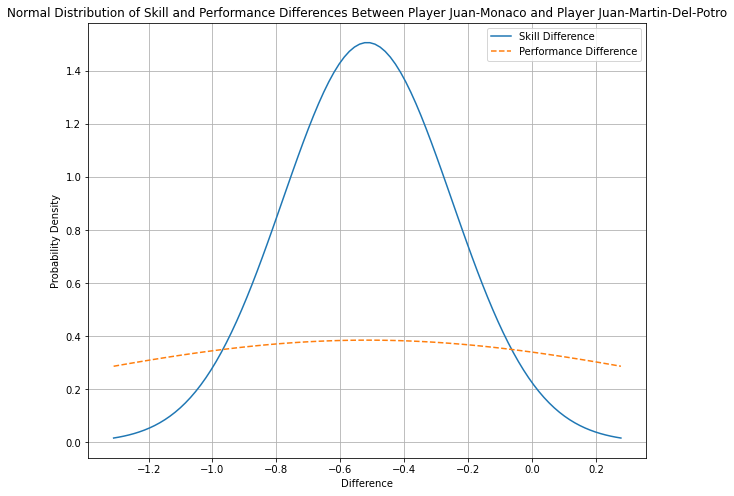

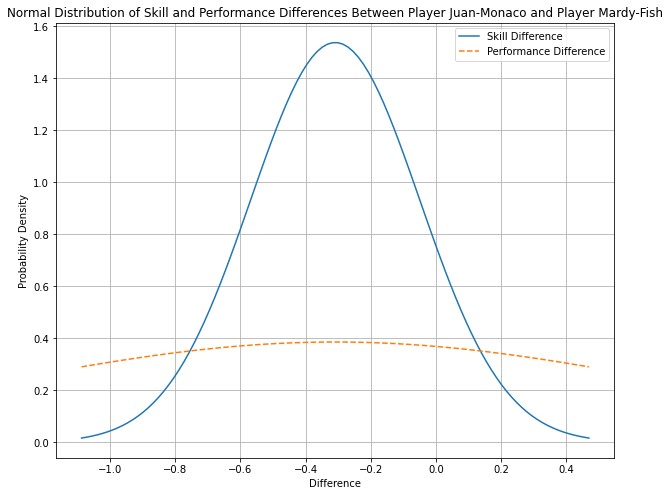

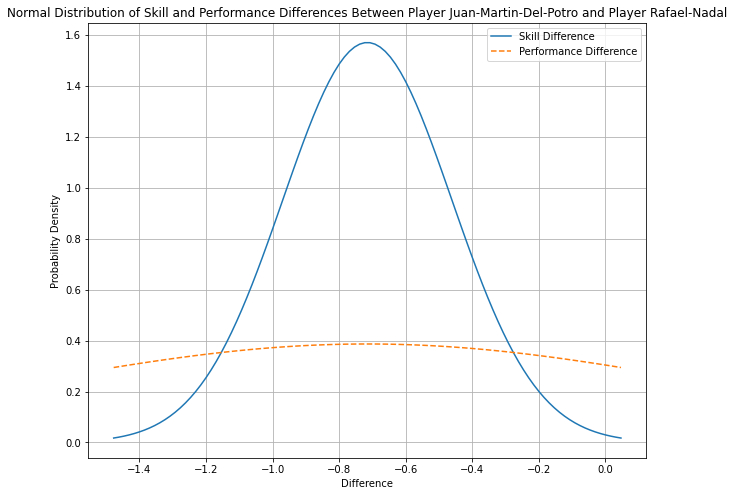

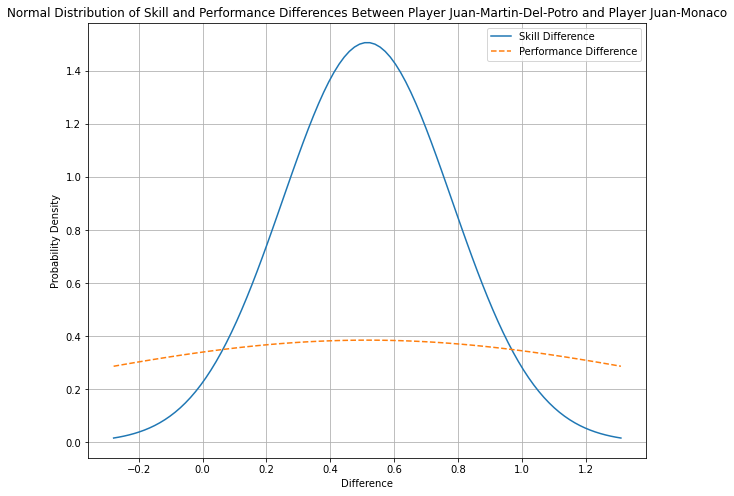

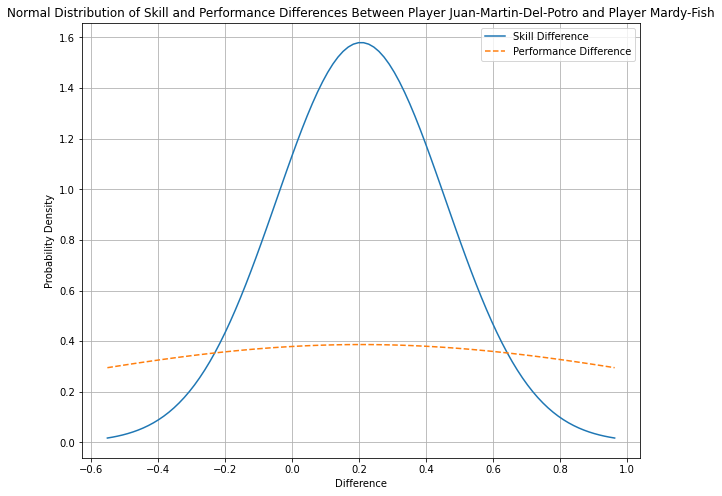

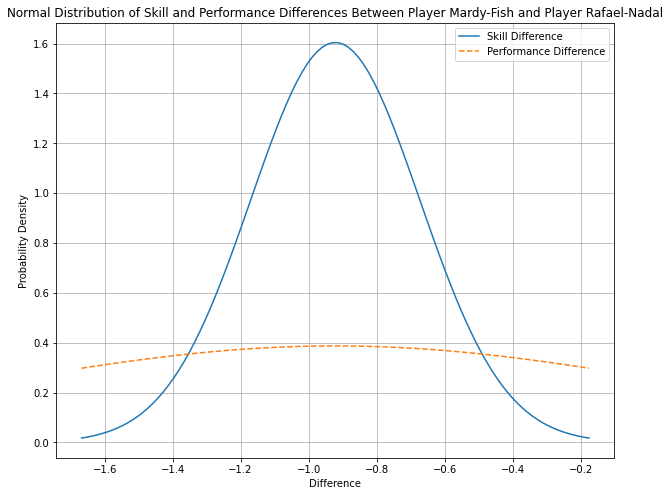

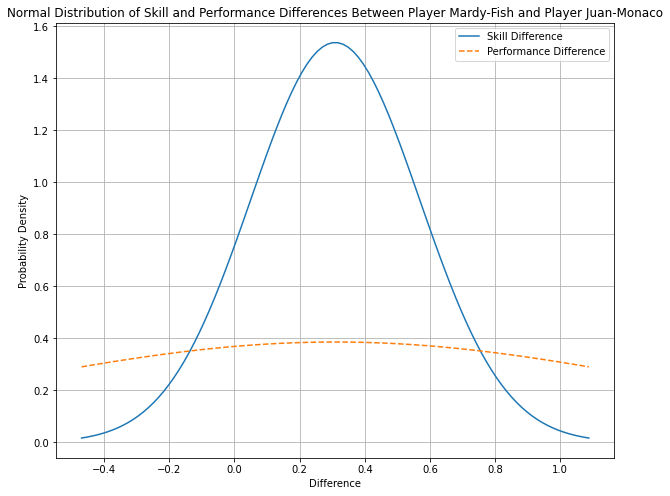

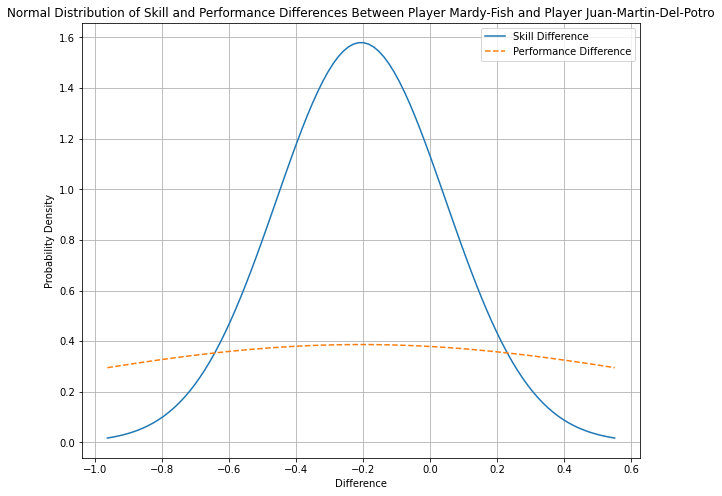

In [91]:
# Iterating through each pair of players
for i in range(4):
    for j in range(4):
        if i != j:
            # Calculate the mean and variance for skill difference
            mean_diff = mean_player_skills[i, -1] - mean_player_skills[j, -1]
            var_skill_diff = 1/precision_player_skills[i, -1] + 1/precision_player_skills[j, -1]

            # Calculate the mean and variance for performance difference (with perf_var = 1)
            perf_var = 1
            var_perf_diff = var_skill_diff + perf_var

            # Define a range of values for plotting the distributions
            x = np.linspace(mean_diff - 3*np.sqrt(var_skill_diff), mean_diff + 3*np.sqrt(var_skill_diff), 100)

            # Plotting the distributions
            plt.figure(figsize=(10, 8))

            # Skill difference distribution
            plt.plot(x, norm.pdf(x, mean_diff, np.sqrt(var_skill_diff)), label="Skill Difference")

            # Performance difference distribution
            plt.plot(x, norm.pdf(x, mean_diff, np.sqrt(var_perf_diff)), label="Performance Difference", linestyle='--')

            plt.title(f"Normal Distribution of Skill and Performance Differences Between Player {W[i, 0]} and Player {W[j, 0]}")
            plt.xlabel("Difference")
            plt.ylabel("Probability Density")
            plt.legend()
            plt.grid(True)
            plt.show()



In [62]:
mean_gibbs.shape

(107, 1100)

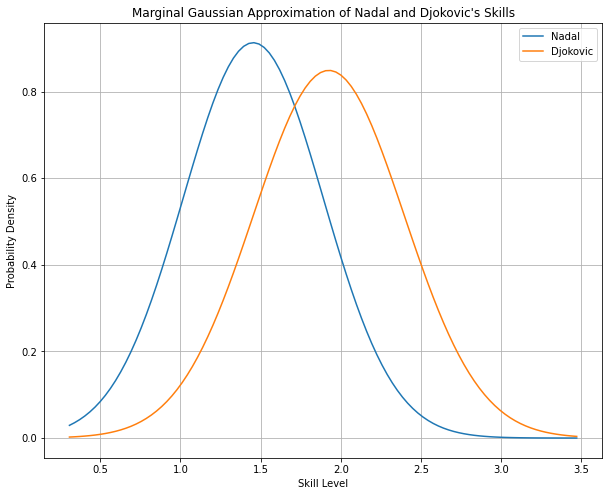

In [90]:
# Player IDs for Nadal and Djokovic
id_nadal = 0
id_djokovic = 15

# Burn-in period (e.g., 20% of the iterations)
burn_in = 200

# Method 1: Marginal Gaussian Approximation
# Extracting post-burn-in samples for Nadal and Djokovic
mean_nadal = skill_samples[id_nadal, burn_in:]
var_nadal = skill_samples[id_nadal, burn_in:]
mean_djokovic = skill_samples[id_djokovic, burn_in:]
var_djokovic = skill_samples[id_djokovic, burn_in:]

# Calculating the overall mean and variance for each player
mean_nadal_avg = np.mean(mean_nadal)
var_nadal_avg = np.std(var_nadal)
mean_djokovic_avg = np.mean(mean_djokovic)
var_djokovic_avg = np.std(var_djokovic)

# Display the results
(mean_nadal_avg, var_nadal_avg), (mean_djokovic_avg, var_djokovic_avg)

import matplotlib.pyplot as plt

# Define a range for plotting
x_range = np.linspace(mean_nadal_avg - 6*var_nadal_avg, mean_djokovic_avg + 7*var_djokovic_avg, 100)

# Marginal Gaussian Approximation Plot
plt.figure(figsize=(10, 8))
plt.plot(x_range, norm.pdf(x_range, mean_nadal_avg, np.sqrt(var_nadal_avg)), label="Nadal")
plt.plot(x_range, norm.pdf(x_range, mean_djokovic_avg, np.sqrt(var_djokovic_avg)), label="Djokovic")
plt.title("Marginal Gaussian Approximation of Nadal and Djokovic's Skills")
plt.xlabel("Skill Level")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()



In [64]:
data_points = np.zeros((2, skill_samples.shape[1] - burn_in))
mean_joint = np.zeros(2)
data_points[0, :] = skill_samples[id_djokovic, burn_in:]
data_points[1, :] = skill_samples[id_nadal, burn_in:]
mean_joint[0] = np.mean(data_points[0, :])
mean_joint[1] = np.mean(data_points[1, :])

cov_joint = np.cov(data_points)


In [65]:
mean_joint, cov_joint

(array([1.92533183, 1.45412317]),
 array([[0.04885161, 0.00780199],
        [0.00780199, 0.03653073]]))

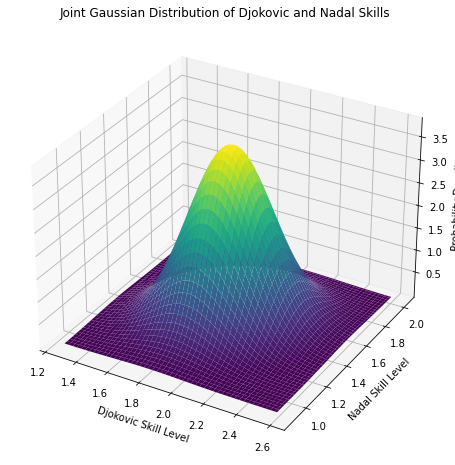

In [66]:
from scipy.stats import multivariate_normal
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Define a range for plotting
x_range = np.linspace(mean_joint[0] - 3*np.sqrt(cov_joint[0, 0]), mean_joint[0] + 3*np.sqrt(cov_joint[0, 0]), 100)
y_range = np.linspace(mean_joint[1] - 3*np.sqrt(cov_joint[1, 1]), mean_joint[1] + 3*np.sqrt(cov_joint[1, 1]), 100)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the joint probability density
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = multivariate_normal.pdf([X[i,j], Y[i,j]], mean=mean_joint, cov=cov_joint)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis)

ax.set_xlabel('Djokovic Skill Level')
ax.set_ylabel('Nadal Skill Level')
ax.set_zlabel('Probability Density')
ax.set_title('Joint Gaussian Distribution of Djokovic and Nadal Skills')
plt.show()

In [92]:
mean_nadal_avg, var_nadal_avg, mean_djokovic_avg, var_djokovic_avg

(1.454123166528065, 0.1910239307909115, 1.925331830625773, 0.22090118051467808)

In [93]:
mean_joint, cov_joint

(array([1.92533183, 1.45412317]),
 array([[0.04885161, 0.00780199],
        [0.00780199, 0.03653073]]))

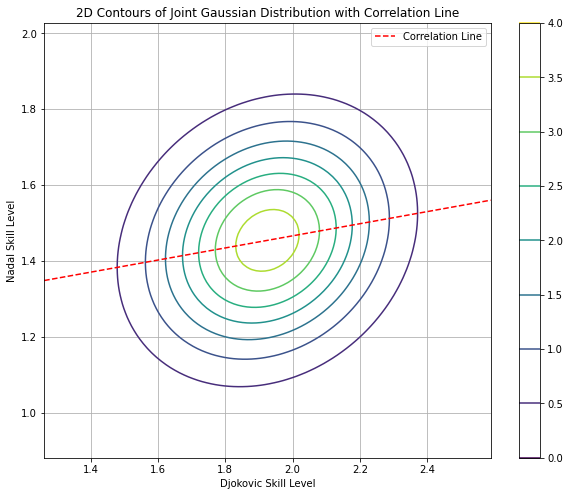

In [67]:
# Define a range for plotting
x_range = np.linspace(mean_joint[0] - 3*np.sqrt(cov_joint[0, 0]), mean_joint[0] + 3*np.sqrt(cov_joint[0, 0]), 100)
y_range = np.linspace(mean_joint[1] - 3*np.sqrt(cov_joint[1, 1]), mean_joint[1] + 3*np.sqrt(cov_joint[1, 1]), 100)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the joint probability density
Z = multivariate_normal.pdf(np.dstack((X, Y)), mean=mean_joint, cov=cov_joint)

# Create the 2D contour plot
plt.figure(figsize=(10, 8))
contour = plt.contour(X, Y, Z, cmap='viridis')

# Plot the correlation line
slope = cov_joint[0, 1] / cov_joint[0, 0]
intercept = mean_joint[1] - slope * mean_joint[0]
plt.plot(x_range, slope * x_range + intercept, 'r--', label='Correlation Line')

plt.xlabel('Djokovic Skill Level')
plt.ylabel('Nadal Skill Level')
plt.title('2D Contours of Joint Gaussian Distribution with Correlation Line')
plt.colorbar(contour)
plt.legend()
plt.grid(True)
plt.show()


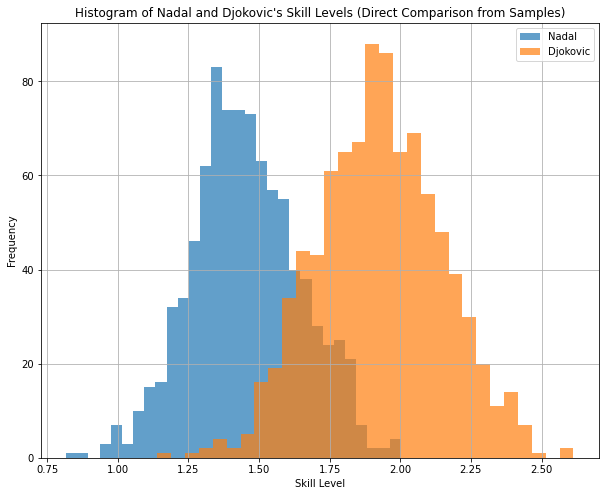

In [89]:
# Direct Comparison from Samples Plot
plt.figure(figsize=(10, 8))
plt.hist(mean_nadal, bins=30, alpha=0.7, label="Nadal")
plt.hist(mean_djokovic, bins=30, alpha=0.7, label="Djokovic")
plt.title("Histogram of Nadal and Djokovic's Skill Levels (Direct Comparison from Samples)")
plt.xlabel("Skill Level")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()



In [94]:
# Assuming we have the indices for the four players
id_djokovic = 15
id_nadal = 0
id_federer = 4  # Mock index for Federer
id_murray = 10  # Mock index for Murray

burn_in = 200  # Example burn-in period

# Initialize the data points array and mean_joint for 4 players
data_points = np.zeros((4, skill_samples.shape[1] - burn_in))
mean_joint = np.zeros(4)

# Extract post-burn-in skill samples for all four players
for i, player_id in enumerate([id_djokovic, id_nadal, id_federer, id_murray]):
    data_points[i, :] = skill_samples[player_id, burn_in:]
    mean_joint[i] = np.mean(data_points[i, :])

# Calculate the covariance matrix for the skills of all four players
cov_joint = np.cov(data_points)

# Now we have the mean_joint and cov_joint for all four players
mean_joint, cov_joint


(array([1.92533183, 1.45412317, 1.52164248, 1.27940539]),
 array([[0.04885161, 0.00780199, 0.01090825, 0.00397719],
        [0.00780199, 0.03653073, 0.01190671, 0.0074827 ],
        [0.01090825, 0.01190671, 0.041927  , 0.00278117],
        [0.00397719, 0.0074827 , 0.00278117, 0.04423712]]))

In [95]:
# Function to calculate the higher skill probability using the joint Gaussian method
def higher_skill_joint(mean_joint, cov_joint, player1, player2):
    mean_diff = mean_joint[player1] - mean_joint[player2]
    var_diff = cov_joint[player1, player1] + cov_joint[player2, player2] - 2 * cov_joint[player1, player2]
    prob = 1 - norm.cdf(-mean_diff / np.sqrt(var_diff))
    return prob

num_players = mean_joint.shape[0]

# Create a matrix to store the probabilities
prob_matrix = np.zeros((num_players, num_players))

# Calculate the probability that the skill of one player is higher than the other
for i in range(num_players):
    for j in range(num_players):
        if i != j:
            prob_matrix[i, j] = higher_skill_joint(mean_joint, cov_joint, i, j)

print(prob_matrix)


[[0.         0.96277416 0.93788286 0.98657737]
 [0.03722584 0.         0.38635236 0.75209845]
 [0.06211714 0.61364764 0.         0.80323532]
 [0.01342263 0.24790155 0.19676468 0.        ]]


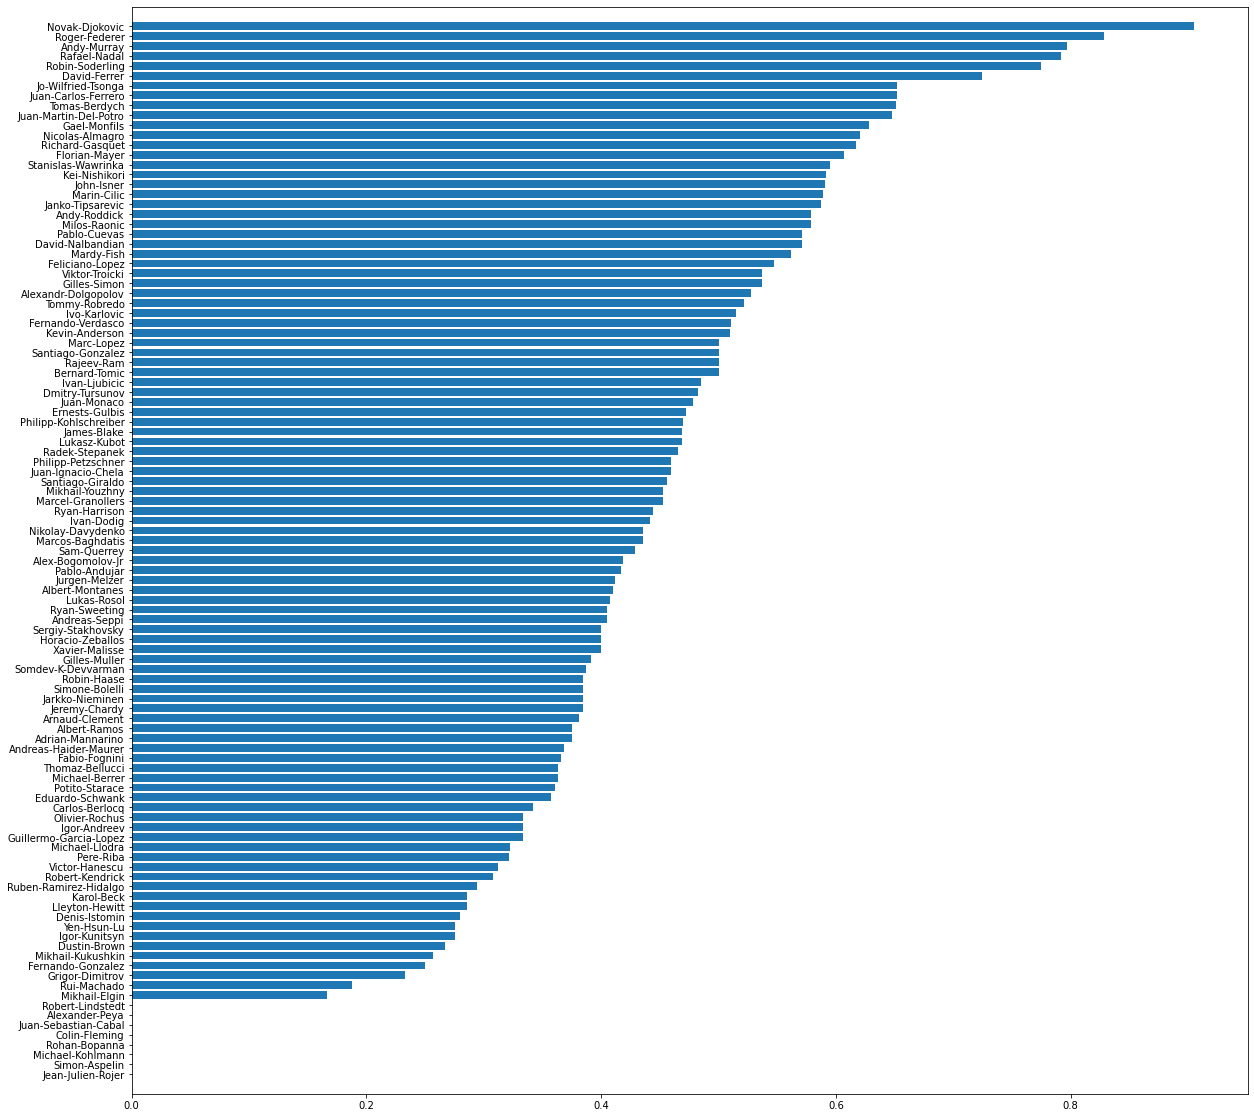

In [69]:
rank_empirical = np.zeros(M)
win_lose = np.zeros((M, 2))
for i in range(G.shape[0]):
    win_lose[G[i, 0] ,0] += 1
    win_lose[G[i, 1] ,1] += 1
rank_empirical = win_lose[:, 0] / (win_lose[:, 0] + win_lose[:, 1])

sorted_barplot(rank_empirical, W)

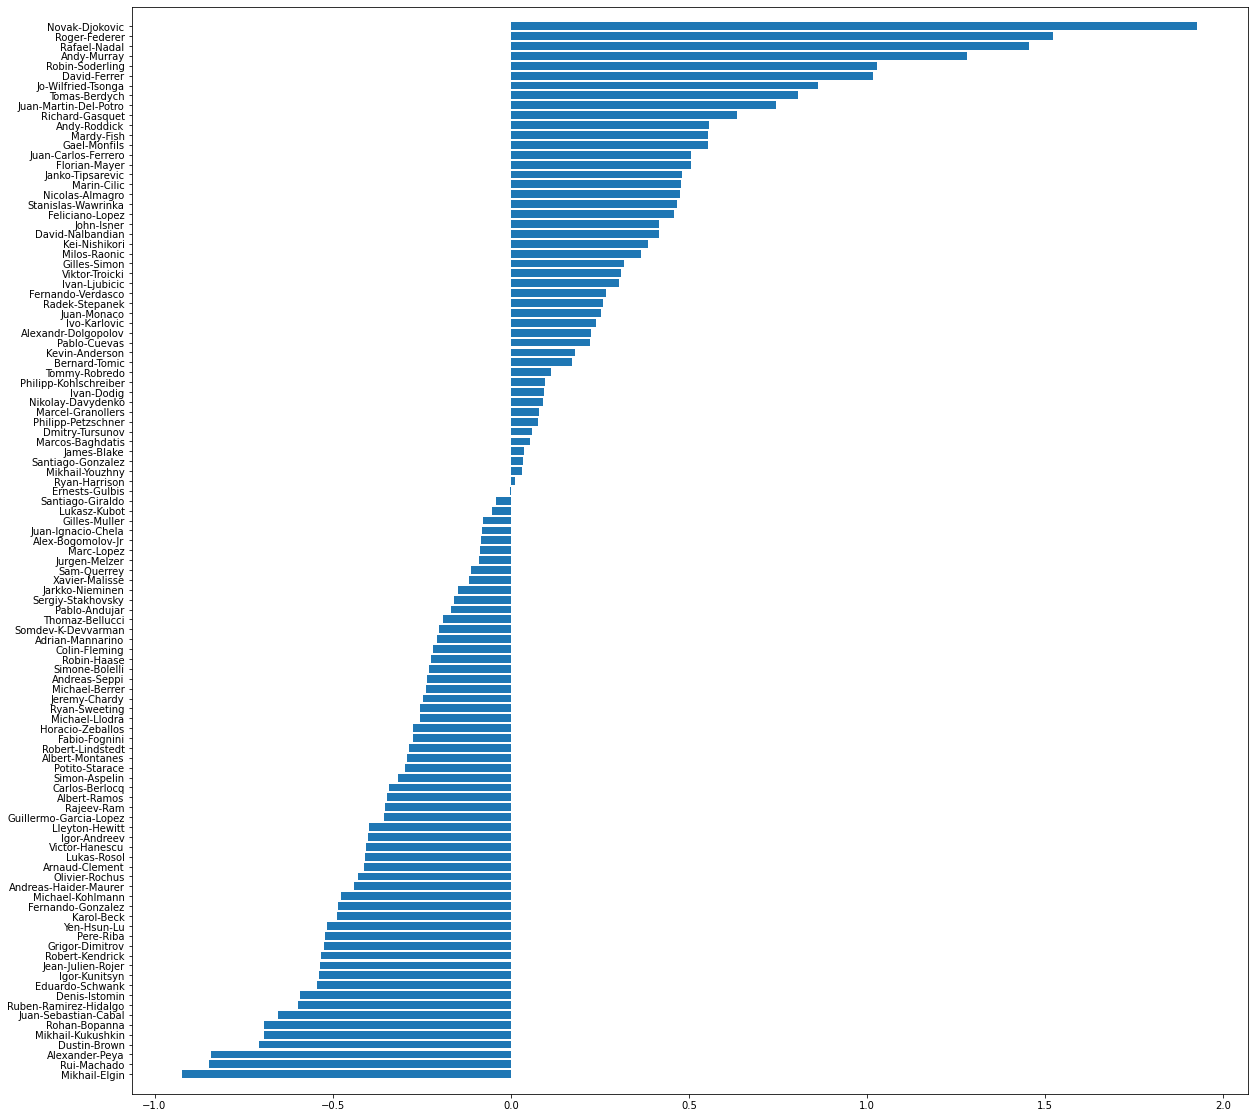

In [70]:
burn_in=200

means_gibbs_skills = np.mean(skill_samples[:,burn_in:],axis=1)
sorted_barplot(means_gibbs_skills,W)

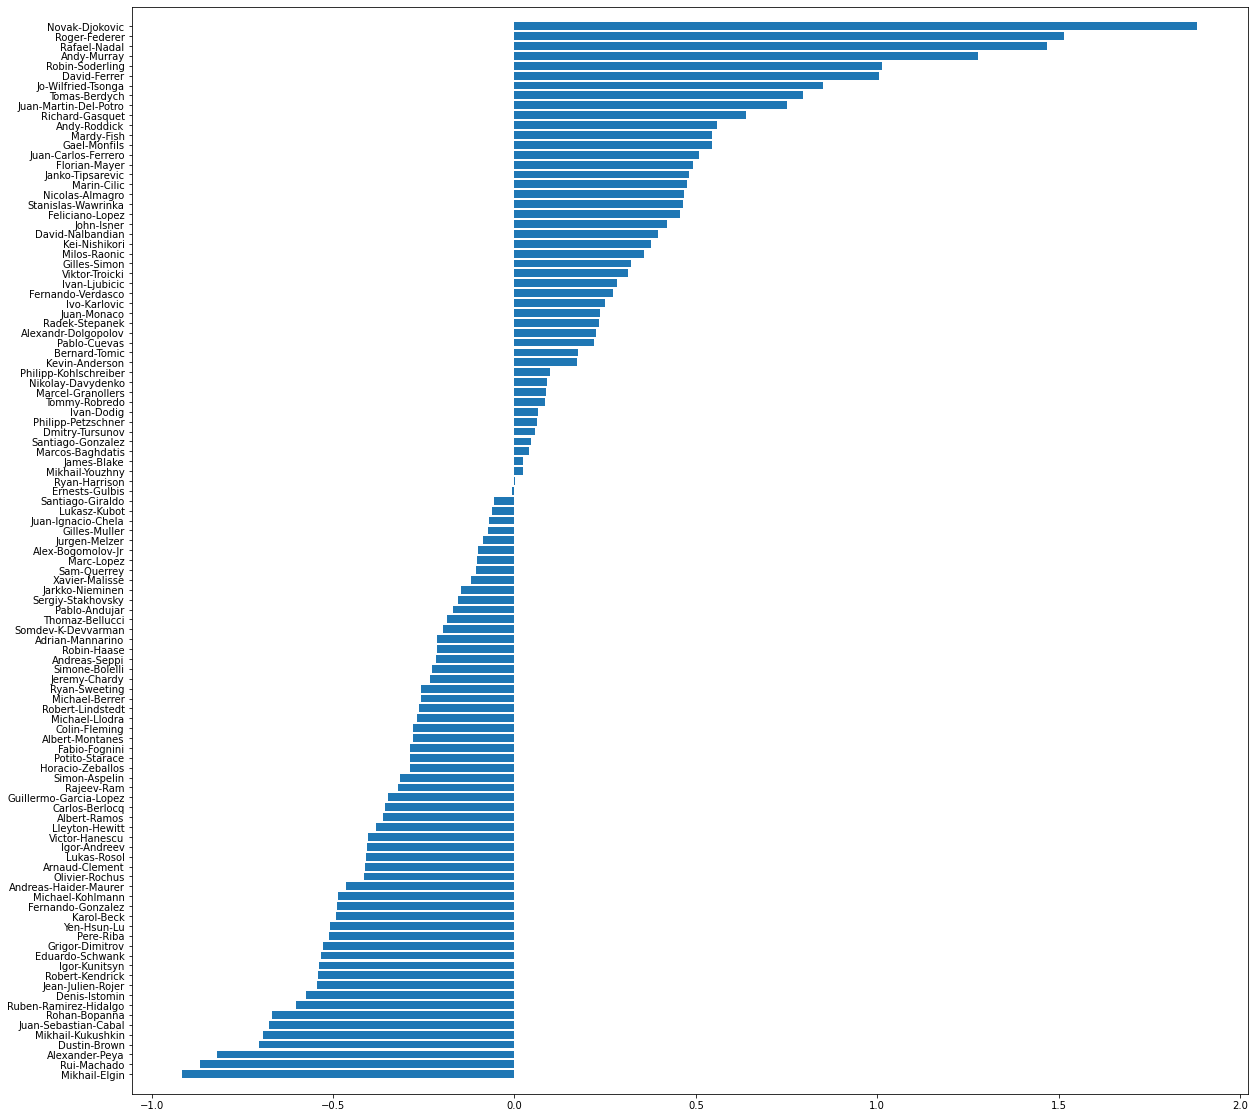

In [71]:
sorted_barplot(mean_player_skills[:, -1], W)